# BTTH - IS - Lab04 - 21110308


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.models import vgg11_bn, vgg13_bn, vgg16_bn, vgg19_bn

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.autonotebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from PIL import Image

import copy
import random
import time

## 1. Thực thi lại code với mạng Convolutional Network mạng tên là VGG như sau với các VGG 11, 13, 16, 19. Và sau đó xuất bảng so sánh đội chính xác của từng mạng


In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
class VGG(nn.Module):
    def __init__(self, features, output_dim):
        super().__init__()

        self.features = features

        self.avgpool = nn.AdaptiveAvgPool2d(7)

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h


def get_vgg_layers(config, batch_norm):

    layers = []
    in_channels = 3

    for c in config:
        assert c == "M" or isinstance(c, int)
        if c == "M":
            layers += [nn.MaxPool2d(kernel_size=2)]
        else:
            conv2d = nn.Conv2d(in_channels, c, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = c

    return nn.Sequential(*layers)

In [4]:
vgg11_config = [64, "M", 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"]

vgg13_config = [64, 64, "M", 128, 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"]

vgg16_config = [
    64,
    64,
    "M",
    128,
    128,
    "M",
    256,
    256,
    256,
    "M",
    512,
    512,
    512,
    "M",
    512,
    512,
    512,
    "M",
]

vgg19_config = [
    64,
    64,
    "M",
    128,
    128,
    "M",
    256,
    256,
    256,
    256,
    "M",
    512,
    512,
    512,
    512,
    "M",
    512,
    512,
    512,
    512,
    "M",
]

In [5]:
output_dim = 10
vgg_layers = []
models = {}
for vgg, key, pretrained_model in zip(
    [vgg11_config, vgg13_config, vgg16_config, vgg19_config],
    ["VGG" + str(i) for i in [11, 13, 16, 19]],
    [
        vgg11_bn(pretrained=True),
        vgg13_bn(pretrained=True),
        vgg16_bn(pretrained=True),
        vgg19_bn(pretrained=True),
    ],
):
    in_features = pretrained_model.classifier[-1].in_features
    final_fc = nn.Linear(in_features, output_dim)
    pretrained_model.classifier[-1] = final_fc

    vgg_layers.append(get_vgg_layers(vgg, batch_norm=True))
    model = VGG(vgg_layers[-1], output_dim)
    model.load_state_dict(pretrained_model.state_dict())
    models[key] = model

for model in models.values():
    print(model)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth
100%|██████████| 507M/507M [00:02<00:00, 179MB/s]
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [6]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


for name, model in models.items():
    print(f"The {name} model has {count_parameters(model):,} trainable parameters")

The VGG11 model has 128,812,810 trainable parameters
The VGG13 model has 128,997,706 trainable parameters
The VGG16 model has 134,309,962 trainable parameters
The VGG19 model has 139,622,218 trainable parameters


In [7]:
pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose(
    [
        transforms.Resize((pretrained_size, pretrained_size)),
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomCrop(pretrained_size, padding=10),
        transforms.ToTensor(),
        transforms.Normalize(mean=pretrained_means, std=pretrained_stds),
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.Resize((pretrained_size, pretrained_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=pretrained_means, std=pretrained_stds),
    ]
)

In [8]:
ROOT = ".data"

train_data = datasets.CIFAR10(
    ROOT, train=True, download=True, transform=train_transforms
)

test_data = datasets.CIFAR10(
    ROOT, train=False, download=True, transform=test_transforms
)

100%|██████████| 170498071/170498071 [00:03<00:00, 55816475.60it/s]


Extracting .data/cifar-10-python.tar.gz to .data
Files already downloaded and verified


In [9]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(
    train_data, [n_train_examples, n_valid_examples]
)

In [10]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [11]:
print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(valid_data)}")
print(f"Number of testing examples: {len(test_data)}")

Number of training examples: 45000
Number of validation examples: 5000
Number of testing examples: 10000


In [12]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min=image_min, max=image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image


def plot_images(images, labels, classes, normalize=True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(10, 10))

    for i in range(rows * cols):

        ax = fig.add_subplot(rows, cols, i + 1)

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis("off")
    return

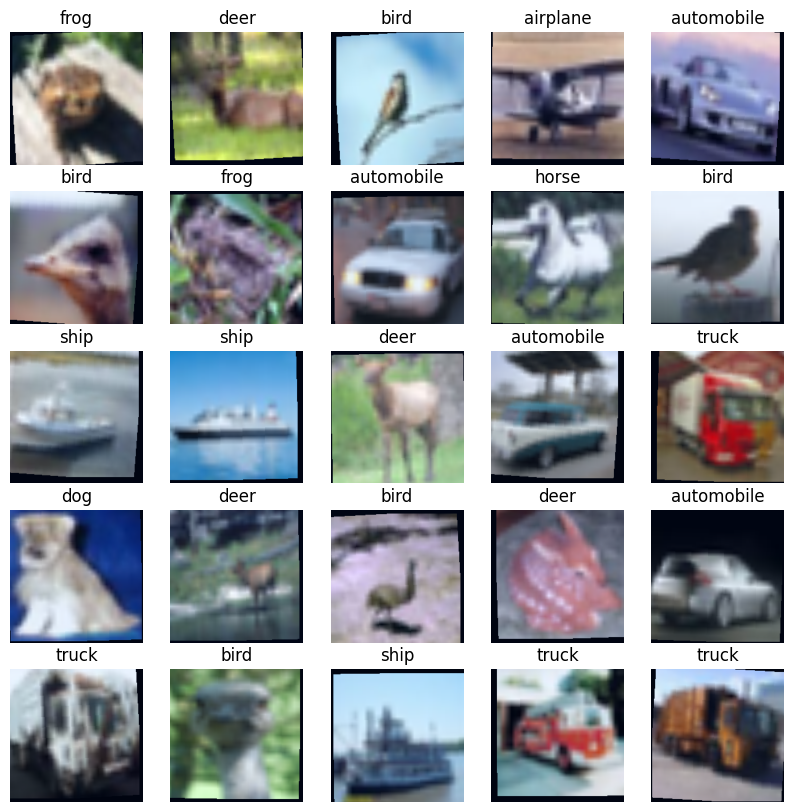

In [13]:
N_IMAGES = 25

images, labels = zip(
    *[(image, label) for image, label in [train_data[i] for i in range(N_IMAGES)]]
)

classes = test_data.classes

plot_images(images, labels, classes)

In [14]:
BATCH_SIZE = 32

train_iterator = data.DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data, batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data, batch_size=BATCH_SIZE)

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

In [16]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc


def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for x, y in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for x, y in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [17]:
EPOCHS = 1
results = []
best_valid_loss = float("inf")

for name, model in models.items():
    model = model.to(device)
    print(name)
    FOUND_LR = 5e-4

    params = [
        {"params": model.features.parameters(), "lr": FOUND_LR / 10},
        {"params": model.classifier.parameters()},
    ]

    optimizer = optim.Adam(params, lr=FOUND_LR)
    best_valid_loss = float("inf")
    for epoch in range(EPOCHS):

        start_time = time.monotonic()

        train_loss, train_acc = train(
            model, train_iterator, optimizer, criterion, device
        )
        valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), f"/kaggle/working/{name}.pt")

        end_time = time.monotonic()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        print(f"Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s")
        print(f"\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%")
        print(f"\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%")

    model.load_state_dict(torch.load(f"/kaggle/working/{name}.pt"))
    test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
    print(f"Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%")
    results.append(
        [name, train_acc, train_loss, valid_acc, valid_loss, test_acc, test_loss]
    )

VGG11


Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 5m 34s
	Train Loss: 0.472 | Train Acc: 84.47%
	 Val. Loss: 0.291 |  Val. Acc: 90.86%


Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Test Loss: 0.300 | Test Acc: 90.59%
VGG13


Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 7m 25s
	Train Loss: 0.481 | Train Acc: 84.01%
	 Val. Loss: 0.337 |  Val. Acc: 89.27%


Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Test Loss: 0.336 | Test Acc: 89.64%
VGG16


Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 8m 29s
	Train Loss: 0.432 | Train Acc: 85.98%
	 Val. Loss: 0.274 |  Val. Acc: 90.98%


Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Test Loss: 0.295 | Test Acc: 90.82%
VGG19


Training:   0%|          | 0/1407 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 9m 38s
	Train Loss: 0.421 | Train Acc: 86.56%
	 Val. Loss: 0.300 |  Val. Acc: 90.55%


Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Test Loss: 0.299 | Test Acc: 90.58%


In [18]:
result_df = pd.DataFrame(
    data=results,
    columns=[
        "model",
        "final_train_acc",
        "final_train_loss",
        "final_valid_acc",
        "final_valid_loss",
        "test_acc",
        "test_loss",
    ],
)
display(result_df)

model  final_train_acc  final_train_loss  final_valid_acc  \
0  VGG11         0.844683          0.471918         0.908639   
1  VGG13         0.840063          0.480796         0.892715   
2  VGG16         0.859808          0.432080         0.909833   
3  VGG19         0.865605          0.421107         0.905454   

   final_valid_loss  test_acc  test_loss  
0          0.290731  0.905851   0.299909  
1          0.337060  0.896366   0.335754  
2          0.273672  0.908247   0.295442  
3          0.300269  0.905751   0.298506

## 2. Viết code input 1 bức ảnh bất kỳ và gọi các model 11, 13, 16, 19 xuất ra được thông tin ảnh đó đang chứa đối tượng nào (classification) với xác xuất bao nhiêu.


In [19]:
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for x, y in tqdm(iterator):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs


def plot_confusion_matrix(labels, pred_labels, classes):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(cm, display_labels=classes)
    cm.plot(values_format="d", cmap="Blues", ax=ax)
    plt.xticks(rotation=30)
    return

  0%|          | 0/313 [00:00<?, ?it/s]

Confusion matrix of VGG11 model


  0%|          | 0/313 [00:00<?, ?it/s]

Confusion matrix of VGG13 model


  0%|          | 0/313 [00:00<?, ?it/s]

Confusion matrix of VGG16 model


  0%|          | 0/313 [00:00<?, ?it/s]

Confusion matrix of VGG19 model


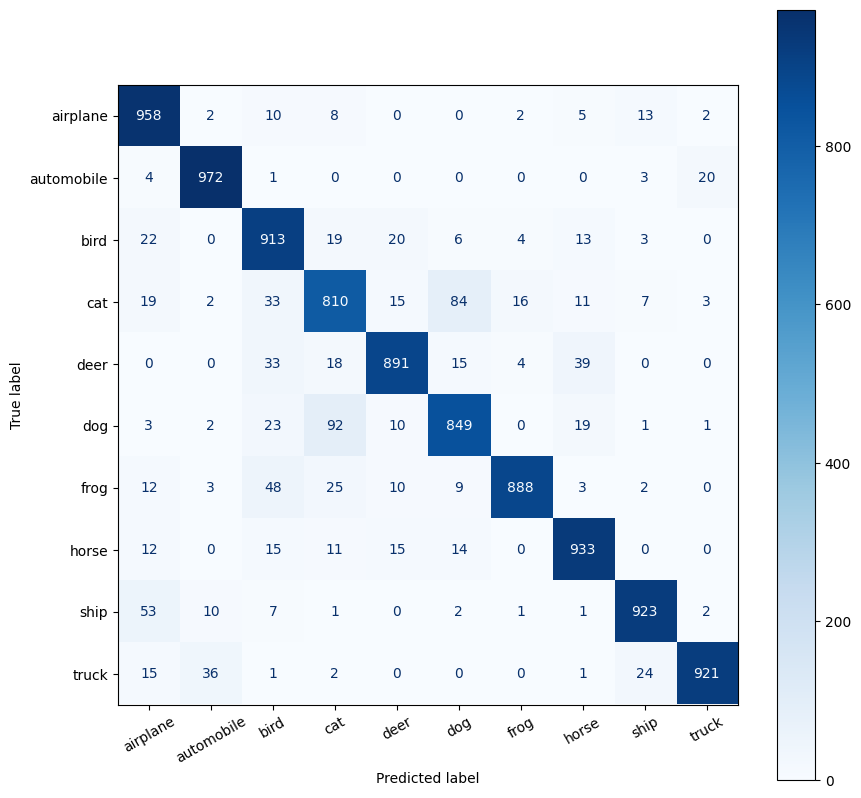

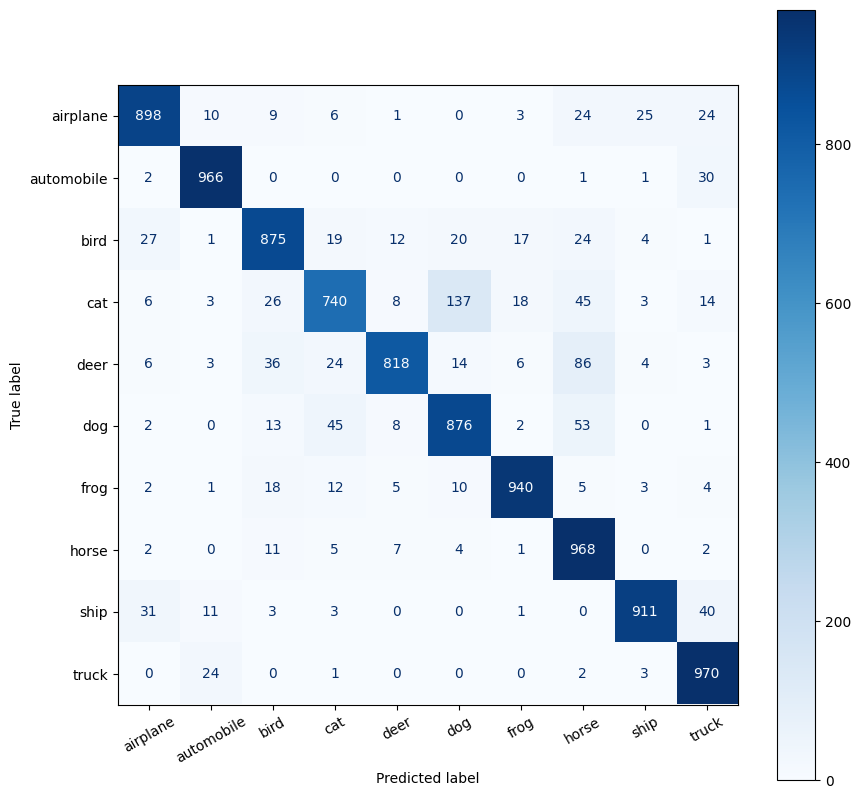

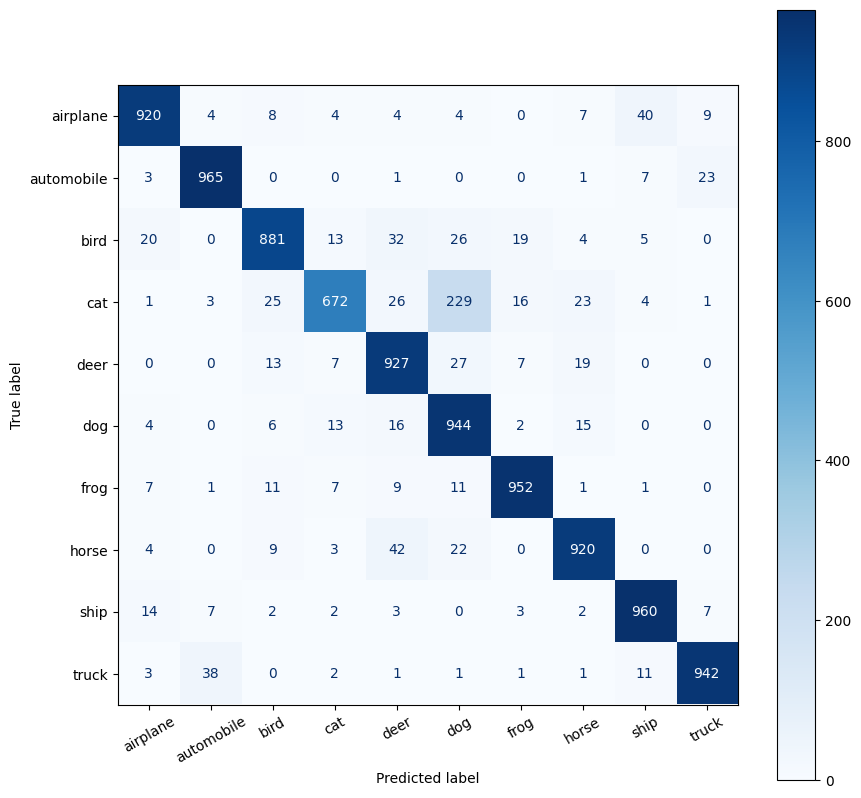

In [20]:
for name, model in models.items():
    images, labels, probs = get_predictions(model, test_iterator)
    pred_labels = torch.argmax(probs, 1)
    print(f"Confusion matrix of {name} model")
    plot_confusion_matrix(labels, pred_labels, classes)

In [21]:
def plot_predicted_images(images, labels, probs, classes, normalize=True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(10, 10))

    for i in range(rows * cols):

        ax = fig.add_subplot(rows, cols, i + 1)

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(f"{classes[labels[i]]}|{torch.max(probs[i]).numpy():.3f}")
        ax.axis("off")
    return

In [22]:
N_IMAGES = 8
cat_dog_filepath = "./cats_and_dogs_filtered"
test_images = []

for classname in ["dogs", "cats"]:
    list_images = os.listdir(cat_dog_filepath + "/validation/" + classname)
    random_images = np.random.randint(low=0, high=len(list_images) + 1, size=N_IMAGES)

    for idx in random_images:
        test_images.append(
            (
                Image.open(
                    os.path.join(
                        cat_dog_filepath, "validation", classname, list_images[idx]
                    )
                ),
                5 if classname == "dogs" else 3,
            )
        )

In [23]:
test_images = [(test_transforms(x), y) for x, y in test_images]
test_iterator = data.DataLoader(test_images, batch_size=1)

In [24]:
test_images[0][0].shape

torch.Size([3, 224, 224])

VGG11


  0%|          | 0/16 [00:00<?, ?it/s]

VGG13


  0%|          | 0/16 [00:00<?, ?it/s]

VGG16


  0%|          | 0/16 [00:00<?, ?it/s]

VGG19


  0%|          | 0/16 [00:00<?, ?it/s]

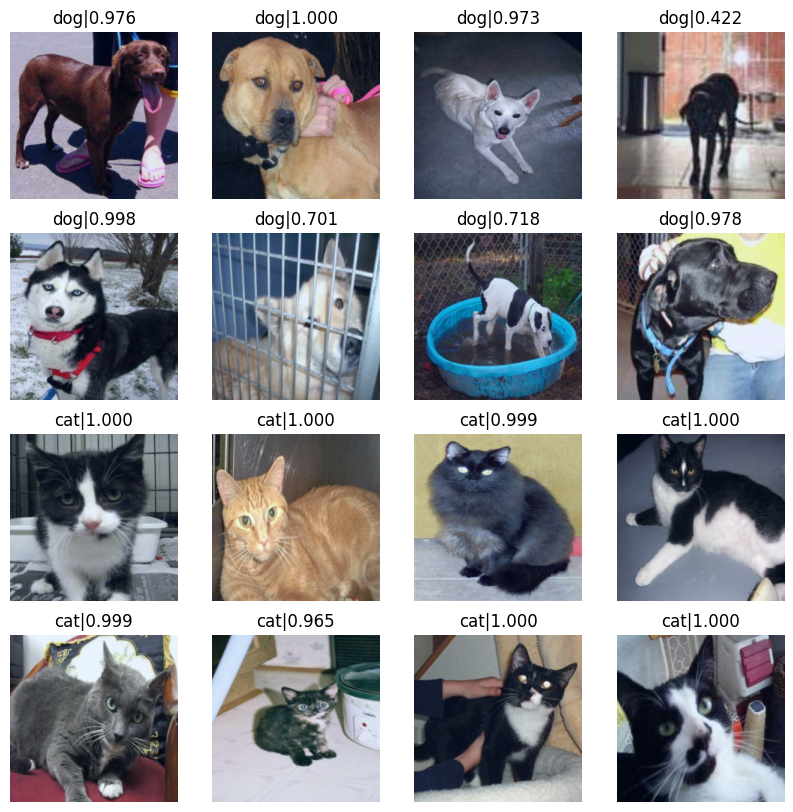

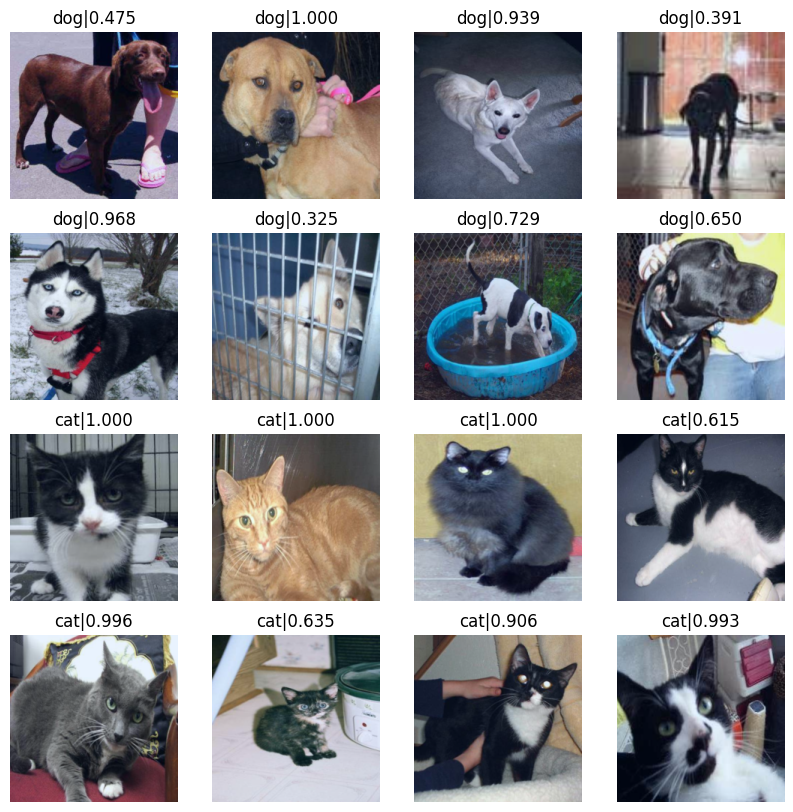

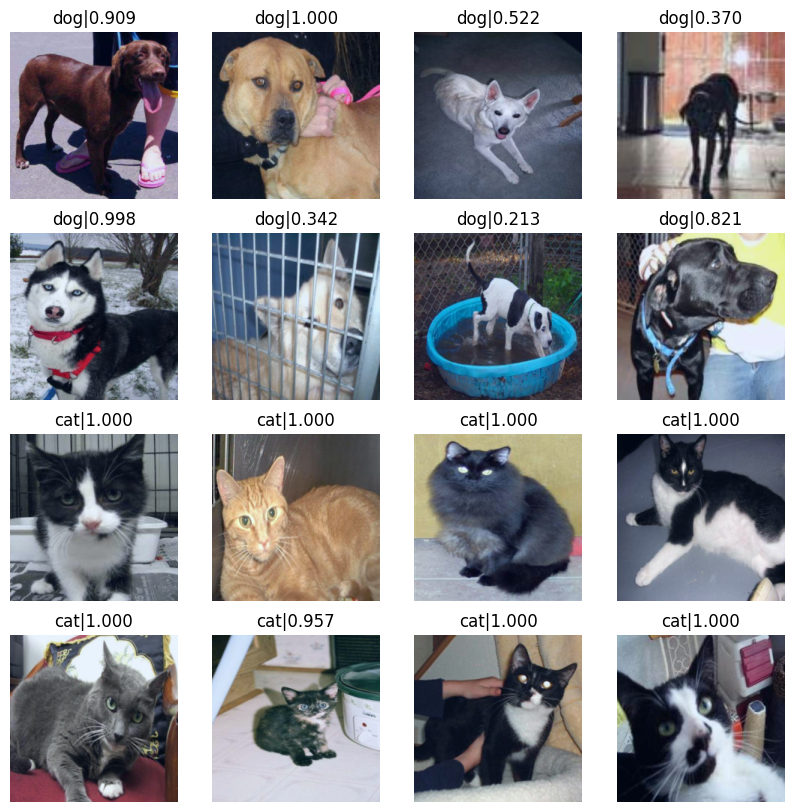

In [25]:
for name, model in models.items():
    print(name)
    model = model.to(device)
    images, labels, probs = get_predictions(model, test_iterator)
    plot_predicted_images(images, labels, probs, classes)

## 3. Làm tương tự và apply thử cho dữ liệu khác là cat and dog trong file đính kèm


In [26]:
output_dim = 2
for name, model in models.items():
    in_features = model.classifier[-1].in_features
    final_fc = nn.Linear(in_features, output_dim)
    model.classifier[-1] = final_fc

for name, model in models.items():
    print(name, ":", model.classifier[-1])

VGG11 : Linear(in_features=4096, out_features=2, bias=True)
VGG13 : Linear(in_features=4096, out_features=2, bias=True)
VGG16 : Linear(in_features=4096, out_features=2, bias=True)
VGG19 : Linear(in_features=4096, out_features=2, bias=True)


In [27]:
data_dir = "/kaggle/input/cats-and-dogs-for-is-lab04/cats_and_dogs_filtered"

train_data = datasets.ImageFolder(data_dir + "/train", transform=train_transforms)
val_data = datasets.ImageFolder(data_dir + "/validation", transform=test_transforms)

In [28]:
print(f"Length of train dataset: {len(train_data)}")
print(f"Length of validation dataset: {len(val_data)}")

Length of train dataset: 2000
Length of validation dataset: 1000


In [29]:
train_iterator = data.DataLoader(dataset=train_data, shuffle=True, batch_size=32)
val_iterator = data.DataLoader(dataset=val_data, shuffle=True, batch_size=32)

In [30]:
EPOCHS = 1
results = []


for name, model in models.items():
    model = model.to(device)
    print(name)
    FOUND_LR = 5e-4

    params = [
        {"params": model.features.parameters(), "lr": FOUND_LR / 10},
        {"params": model.classifier.parameters()},
    ]

    optimizer = optim.Adam(params, lr=FOUND_LR)
    best_valid_loss = float("inf")
    for epoch in range(EPOCHS):

        start_time = time.monotonic()

        train_loss, train_acc = train(
            model, train_iterator, optimizer, criterion, device
        )
        valid_loss, valid_acc = evaluate(model, val_iterator, criterion, device)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss

        end_time = time.monotonic()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        print(f"Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s")
        print(f"\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%")
        print(f"\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%")

    results.append([name, train_acc, train_loss, valid_acc, valid_loss])

VGG11


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 39s
	Train Loss: 0.116 | Train Acc: 96.53%
	 Val. Loss: 0.045 |  Val. Acc: 98.34%
VGG13


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 32s
	Train Loss: 0.123 | Train Acc: 95.04%
	 Val. Loss: 0.044 |  Val. Acc: 98.63%
VGG16


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 35s
	Train Loss: 0.095 | Train Acc: 96.43%
	 Val. Loss: 0.052 |  Val. Acc: 97.95%
VGG19


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 37s
	Train Loss: 0.098 | Train Acc: 96.08%
	 Val. Loss: 0.047 |  Val. Acc: 97.95%


In [31]:
display(
    pd.DataFrame(
        results, columns=["name", "train_acc", "train_loss", "val_acc", "val_loss"]
    )
)

name  train_acc  train_loss   val_acc  val_loss
0  VGG11   0.965278    0.115759  0.983398  0.045482
1  VGG13   0.950397    0.122619  0.986328  0.044048
2  VGG16   0.964286    0.095136  0.979492  0.052380
3  VGG19   0.960813    0.098281  0.979492  0.046883